# Rede covulacional para Redução de ruídos em imagens de galáxias
- PET - Física
- Petiana: Ylana Karolina Santos Lopes
- Data: 18 de Julho de 2025

$\quad$Este `Notebook` tem como o objetivo treinar uma rede neural convulacional para retirar ruídos de imagens de galáxia do Sloan Digital Sky Server (SDSS). Utilizaremos a biblioteca `Pytorch` para montar uma rede do tipo UNet com os dados do dataset Galaxy10. Ao longo deste trabalho será discutido a importância do tratamento dos ruídos em dados astronômicos, como também o funcionamento de redes covolucionais. Informamos que não será necessários conhecimentos prévios no assunto para acompanhar este trabalho, mas fica de indicação o `Notebook` *Classificação de galáxias usando Machine Learning* para mais informações.

O presente `Notebook` será organizado da seguinte forma:

1. *Introdução;*
2. *Ruído Sintético;*
3. *Rede Neural: Arquitetura U-Net;*
4. *Estatísticas;*
5. *Conclusão.*

$\quad$Para o leitor conseguir acompanhar o código, é necessário que sejam instaladas as bibliotecas utilizadas neste `Notebook`. Isto pode ser realizado utilizando o comando `python -m pip install` com os respectivos pacotes em uma janela de terminal.






## Importando as bibliotecas

In [1]:
import urllib.request
from tqdm import tqdm
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline


## Informações sobre as bibliotecas

In [2]:
%load_ext version_information
%version_information matplotlib, numpy, torch, h5py

ModuleNotFoundError: No module named 'version_information'

## 1.  Introdução

$\quad$A astronomia surgiu com o ser humano olhando para o céu e catalogando o que enxergava a olho nu. Assim, o pilar observacional da astronomia e astrofísica manteve e continua seu papel até hoje com instrumentos de escalas enormes tanto em terra quanto no espaço com o singelo objetivo de coletar dados de toda a parcela do Universo que nos é acessível. Todo esse campo de estudo depende fortemente dessas imagens astronômicas que carregam consigo informação sobre os mais diversos corpos celestes, comprovando modelos teóricos e fomentando novos. No entanto, esses dados são frequentemente corrompidos pela presença de ruídos atmosféricos e instrumentais levando a perca de informação importante, e dificultanto análises posteriores.

$\quad$Com o avanço da inteligência artificial, e de ferramentas como redes neurais convolucionais (CNNs), tornou-se possível aplicar técnicas automáticas para o tratamento dessas imagens. As CNNs são particularmente adequadas para tarefas de processamento de imagens devido à sua capacidade de extrair padrões espaciais e características relevantes.Neste trabalho, propomos a utilização de uma rede do tipo UNet, uma arquitetura bastante utilizada em tarefas de segmentação e restauração de imagens, para reduzir ruídos em imagens de galáxias obtidas pelo Sloan Digital Sky Survey (SDSS). Utilizaremos o conjunto de dados Galaxy10, que oferece imagens reais de galáxias rotuladas, e a biblioteca PyTorch para o desenvolvimento e treinamento da rede neural.

$\quad$Primeiro passo é baixar o banco de dados que utilizaremos neste treinamento. O dataset escolhido foi o Galaxy10, que contém cerca de 21 mil imagens de forma 69 x 69 rotuladas. Os rótulos (labels) são geralmente utilizados em projetos de classificação. Como estamos montando um denoiser (uma rede para retirar ruído), os rótulos deste dataset não serão necessários aqui.

In [3]:
urllib.request.urlretrieve("http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", "Galaxy10.h5")

with h5py.File('Galaxy10.h5', 'r') as U:
    images = np.array(U['images'])
    labels = np.array(U['ans'], dtype='int64')

print(f"Galaxy10 dataset: {len(images)} imagens e {len(np.unique(labels))} classes")

Galaxy10 dataset: 21785 imagens e 10 classes


## 2. Ruído Sintético

$\quad$Caso o leitor faça parte da população mundial que usa óculos, já está mais familiarizado com o que será abordado nessa seção. Em astrofísica observacional, todos os dados adquiridos em observação *in situ* ou espaciais acabam tendo os dados influenciados pela interação com os instrumentos, sendo necessário passar um um processamento de imagem para tirar o que chamamos de ruído, e ajustar a estrutura dos dados para a finalizade específica da pesquisa. A etapa de redução do ruído visa limpar os dados de informação desnecessária proveniente do próprio instrumento por causa de flutuações de térmicas, detritos e poluição luminosa. Dessa forma, os dados finais contém a informação mais clara do objeto que está sendo observado, proporcionando análises mais precisas e confiáveis. Um indicativo do ruído nos dados é o chamado SNR (Signal to Noise Ratio) que traduz diretamente para fração do sinal para o ruído - quando maior o SNR melhor.

$\quad$Dois tipos de ruídos serão levados em conta neste trabalho: o ruído do próprio instrumento, geralmente um CCD (couple charged device) que tem natureza gaussiana; e o ruído fotônico, que se caracteriza como a flutuação na chegada dos fotóns no detector, obedecendo uma distribuição de Poisson. Como também a possibilidade de pixels queimados e saturados na imagem crua. Neste `Notebook`, estamos montando um banco de dados com ruído artificial tendo como base as imagens do Galaxy10 levando em conta os ruídos citados acima.

**Figura 1:** Visualização de uma imagem com ruído (esquerda) e uma depois da redução de ruídos (direita). *Fonte: Kevin Francys*

$\quad$Com isso em mente, criaremos a classe `Galaxy10ArrayDataset` com o intuito de retornar imagens do Galaxy10 com o ruído sintético. O ponto mais importante do bloco abaixo é a função `__getitem__` -- onde há o carregamento da imagem e o pré-processamento, retornando um par de imagens: uma limpa (a original) e uma com ruído artificial que acabamos de gerar.

In [4]:
class Galaxy10ArrayDataset(Dataset):
    def __init__(self, images, labels=None, noise_std=0.1,
                 use_poisson=True, burn_ratio=0.01, saturate_ratio=0.01):
        self.images = images.astype(np.float32) / 255.0  # Normalização
        self.labels = labels
        self.noise_std = noise_std          # Ruído Gaussiano
        self.use_poisson = use_poisson      # Ruído de Poisson
        self.burn_ratio = burn_ratio        # fração de pixels queimados (0)
        self.saturate_ratio = saturate_ratio  # fração de pixels saturados (1)

    def __len__(self):
        return len(self.images) # Retorna o número total de imagens

    def __getitem__(self, idx):
        '''
        Nesta etapa, pegamos a imagem com índice `idx` e aplicamos as
        transformações na própria estrutura dos dados para alinhar com o input
        da função interpolate do Pytorch.
        '''
        img = self.images[idx]  # (69, 69, 3) - Dimensões da imagem, e número de canais (RGB)
        img = torch.tensor(img).permute(2, 0, 1)  # (Número de Canais, Altura, Largura)

        '''
        Redimensionamos a imagem de 69x69 para 128x128. Este passo é essencial para garantir
        o funcionamento correto das operações na arquitetura de rede escolhida (U-Net) que
        apresentam melhor desempenho com dimensões divisíveis por potências de 2 - devido a
        simetria das imagens.
        '''
        img = F.interpolate(img.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)
        clean_img = img.clone()

        '''
        Assim, salvamos a imagem limpa (clean_img) e adicionamos o ruído gaussiano inicialmente
        '''
        noisy_img = clean_img + self.noise_std * torch.randn_like(clean_img)

        if self.use_poisson: # Aplica ruído de Poisson simulando contagens de fótons
            scale = 255.0
            img_poisson = torch.poisson(clean_img * scale) / scale
            noisy_img = (noisy_img + img_poisson) / 2.0  # média entre os ruídos


        '''
        Para adicionar os pixels queimados e saturados, montamos uma máscara aleatória
        que zera os pixels em todos os canais desse ponto (para um pixel queimado), e
        força o valor 1.0 (valor máximo, já que o intervalo válido é [0,1]) para simular um
        saturado.
        '''
        # Adiciona pixels queimados (0)
        burn_mask = torch.rand_like(noisy_img[0]) < self.burn_ratio
        for c in range(3):
            noisy_img[c][burn_mask] = 0.0

        # Adiciona pixels saturados (1)
        saturate_mask = torch.rand_like(noisy_img[0]) < self.saturate_ratio
        for c in range(3):
            noisy_img[c][saturate_mask] = 1.0

        # Retorna uma imagem com ruído sintético e uma limpa
        noisy_img = torch.clamp(noisy_img, 0.0, 1.0)
        return noisy_img, clean_img


$\quad$Podemos ver o resultado desse pré-processamento abaixo comparando a imagem original (limpa) com a correspondente contendo o ruído sintético que construímos, no painel de resultado do treinamento.

## 3. Rede Neural: Arquitetura U-Net

$\quad$As inteligênc

In [5]:
# 4. UNet simples para autoencoder
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1),nn.ReLU())
        self.up1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),nn.ReLU())
        self.final = nn.Conv2d(128, 3, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x = self.up1(x2)
        x = torch.cat([x, x1], dim=1)
        return torch.sigmoid(self.final(x))

In [6]:
# Criar dataset completo

dataset = Galaxy10ArrayDataset(
    images,
    labels=labels,
    noise_std=0.05,
    use_poisson=True,
    burn_ratio=0.01,
    saturate_ratio=0.01
)


# Divisão treino/validação/teste
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [7]:
# 6. Treinamento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 15
loss_val = []
loss_train = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    # tqdm no loop de treino
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Training", leave=False)
    for noisy, clean in loop:
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        loop.set_postfix(loss=loss.item())  # mostra a loss atual

    avg_train_loss = train_loss / len(train_loader)
    loss_train.append(avg_train_loss)

    model.eval()
    val_loss = 0.0

    # tqdm no loop de validação
    loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epochs} - Validation", leave=False)
    with torch.no_grad():
        for noisy, clean in loop_val:
            noisy, clean = noisy.to(device), clean.to(device)
            output = model(noisy)
            val_loss += criterion(output, clean).item()

    avg_val_loss = val_loss / len(val_loader)
    loss_val.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch 1/15, Training Loss: 0.0189, Validation Loss: 0.0006


Epoch 2/15, Training Loss: 0.0003, Validation Loss: 0.0002


Epoch 3/15, Training Loss: 0.0002, Validation Loss: 0.0002


Epoch 4/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 5/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 6/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 7/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 8/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 9/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 10/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 11/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 12/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 13/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 14/15, Training Loss: 0.0001, Validation Loss: 0.0001


Epoch 15/15, Training Loss: 0.0001, Validation Loss: 0.0001


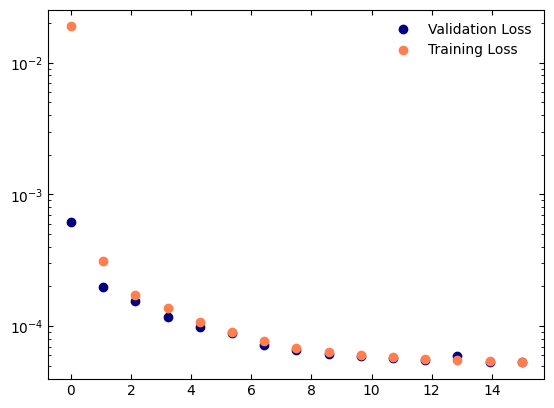

In [8]:
x = np.linspace(0,n_epochs, n_epochs)

plt.tick_params(direction='in', which = 'both', bottom = 1, top =1, left = 1, right = 1)
plt.scatter(x,loss_val,c = 'navy', label = 'Validation Loss')
plt.scatter(x, loss_train, c = 'coral', label = 'Training Loss')
plt.yscale('log')

plt.savefig('loss.png', dpi=300, bbox_inches='tight')

plt.legend(frameon=False)

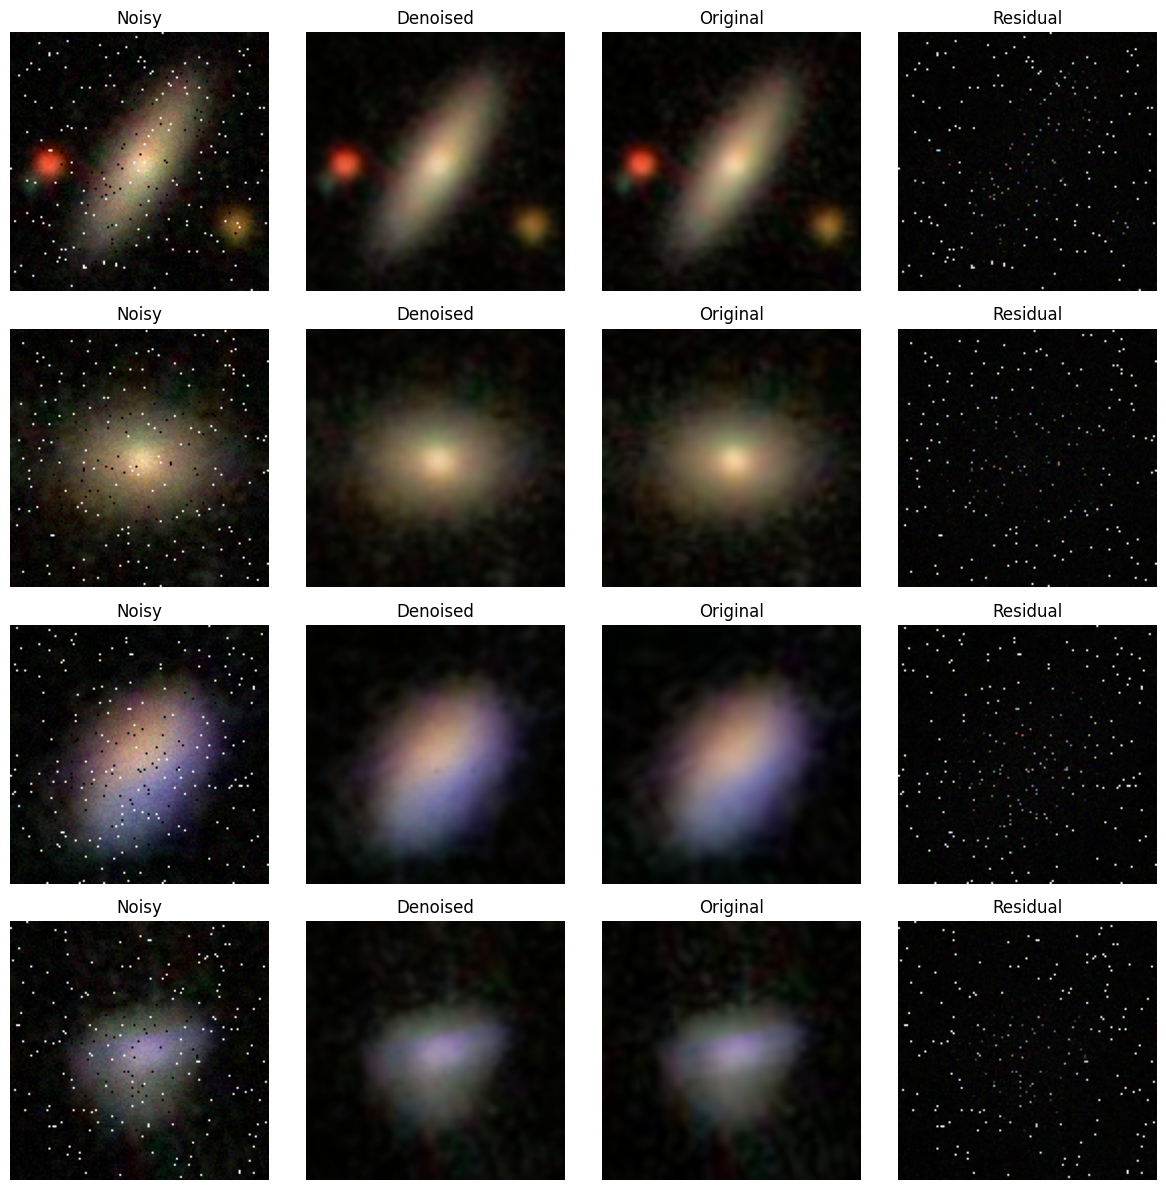

In [9]:

# 7. Visualização dos resultados
def show_images(noisy, output, clean, num=4, save_path=None):
    fig, axes = plt.subplots(num, 4, figsize=(12, num * 3))
    for i in range(num):
        noisy_img = noisy[i].permute(1, 2, 0).cpu().numpy().clip(0, 1)
        output_img = output[i].permute(1, 2, 0).cpu().numpy().clip(0, 1)
        clean_img = clean[i].permute(1, 2, 0).cpu().numpy().clip(0, 1)
        residual = np.abs(noisy_img - output_img)


        axes[i, 0].imshow(noisy_img)
        axes[i, 0].set_title("Noisy")
        axes[i, 1].imshow(output_img)
        axes[i, 1].set_title("Denoised")
        axes[i, 2].imshow(clean_img)
        axes[i, 2].set_title("Original")
        axes[i, 3].imshow(residual, cmap='hot', vmin=0, vmax=0.5)
        axes[i, 3].set_title("Residual"); axes[i, 3].axis('off')

        for ax in axes[i]:
            ax.axis('off')
    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

# Exibir amostras
model.eval()
noisy, clean = next(iter(test_loader))
noisy = noisy.to(device)
with torch.no_grad():
    output = model(noisy)
show_images(noisy, output, clean, save_path='painel_denoiser.png')


In [10]:
def psnr_batch(output, target, max_val=1.0):
    mse = torch.mean((output - target) ** 2, dim=[1, 2, 3])  # MSE para cada imagem no batch
    psnr = 10 * torch.log10(max_val**2 / mse)
    return psnr.mean().item()  # PSNR médio do batch


model.eval()
val_loss = 0
val_psnr = 0
with torch.no_grad():
    for noisy, clean in val_loader:
        noisy, clean = noisy.to(device), clean.to(device)
        output = model(noisy)
        loss = criterion(output, clean)
        val_loss += loss.item()
        val_psnr += psnr_batch(output, clean)

val_loss /= len(val_loader)
val_psnr /= len(val_loader)
print(f"Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f} dB")


Val Loss: 0.0001 | Val PSNR: 42.82 dB


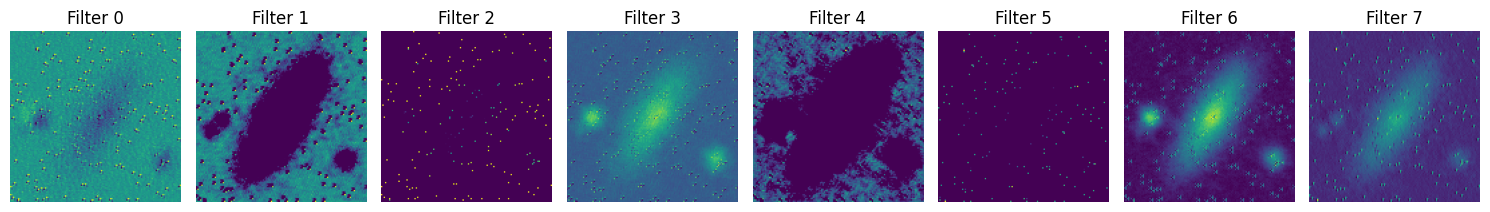

In [11]:
def visualize_feature_maps(model, image_tensor):
    model.eval()
    with torch.no_grad():
        # Get features after first conv layer (down1)
        x = model.down1(image_tensor.unsqueeze(0).to(device))  # shape: [1, 64, H, W]
        x = x.squeeze(0).cpu()  # remove batch dimension

        # Plot a few feature maps
        n_features = min(8, x.shape[0])  # show up to 8 channels
        fig, axes = plt.subplots(1, n_features, figsize=(15, 5))
        for i in range(n_features):
            axes[i].imshow(x[i], cmap='viridis')
            axes[i].set_title(f'Filter {i}')
            axes[i].axis('off')
        plt.tight_layout()
        plt.savefig('featura_map.png', dpi=300, bbox_inches='tight')

        plt.show()


noisy, _ = next(iter(test_loader))
visualize_feature_maps(model, noisy[0])


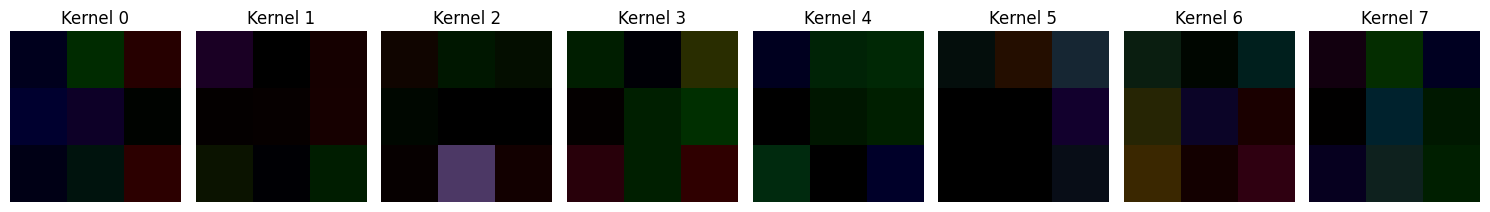

In [12]:
def plot_conv_weights(model):
    weights = model.down1[0].weight.data.cpu()  # first conv layer weights
    n_kernels = weights.shape[0]
    fig, axes = plt.subplots(1, min(8, n_kernels), figsize=(15, 3))
    for i in range(min(8, n_kernels)):
        kernel = weights[i].permute(1, 2, 0)  # shape: [H, W, C]
        axes[i].imshow(kernel.numpy(), interpolation='nearest')
        axes[i].axis('off')
        axes[i].set_title(f'Kernel {i}')
    plt.tight_layout()
    plt.savefig('conv_weights.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_conv_weights(model)


## Referências

**[1]** Ronneberger, O., Fischer, P. and Brox, T. (2015). U-Net: Convolutional networks for biomedical image segmentation. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.1505.04597;

**[2]**
